In [18]:
import os
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm as tqdm
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from datetime import datetime
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
print(torch.__version__)

1.12.1+cu116


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
data_dir = str(Path(fr"./data/train.csv"))

save_dir = str(Path(fr"./runs/exp"))

In [31]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# define the input size of the model
input_size = 160

epoch_num = 300

dtype = torch.float64

# Learning Rate
LR = 2e-5
EPS = 1e-7
LR_STEP = 100
LR_GAMMA = 1

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        data = pd.read_csv(data_dir)
        self.inputs = data[['x1', 'x2']].to_numpy()
        self.outputs = data['y'].to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype= torch.float)
        output_data = torch.tensor(self.outputs[idx], dtype= torch.float)

        if self.transform:
            input_data = self.transform(input_data)

        return input_data, output_data

In [7]:
dataset = CustomDataset(data_dir)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])


dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
               for x, y, z in zip(['train', 'valid'], [train_dataset, valid_dataset], [True, False])}


In [8]:
# class DeepModel(nn.Module):
#     def __init__(self, layer_sizes):
#         super(DeepModel, self).__init__()

#         self.layers = nn.ModuleList()

#         for i in range(len(layer_sizes) - 1):
#             layer = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
#             init.xavier_uniform_(layer.weight)  # 使用Xavier初始化
#             self.layers.append(layer)

#         self.activation = nn.LeakyReLU()

#     def forward(self, x):
#         for layer in self.layers[:-1]:
#             x = self.activation(layer(x))
        
#         x = self.layers[-1](x)  # 最后一层不使用激活函数
#         return x

In [9]:
class DeepModelWithBN(nn.Module):
    def __init__(
            self, 
            layer_sizes):
        super().__init__()

        self.layers = nn.ModuleList()

        for i in range(len(layer_sizes) - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i + 1]).to(dtype)
            nn.init.xavier_uniform_(layer.weight)  # 使用Xavier初始化
            self.layers.append(layer)
            
            if i != len(layer_sizes) - 2:  # 不在最后一个线性层后使用批量归一化
                bn = nn.BatchNorm1d(layer_sizes[i + 1]).to(dtype)
                self.layers.append(bn)

        self.activation = nn.LeakyReLU()

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if isinstance(layer, nn.Linear):  # 只在线性层后使用激活函数
                x = self.activation(x)
        
        x = self.layers[-1](x)  # 最后一层不使用激活函数
        return x

In [10]:
class EasyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 128)
        self.layer2 = nn.Linear(128, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [35]:
model_name = 'DeepModelWithBN'
model_args = [[2, 128, 128, 1]]


model = DeepModelWithBN(*model_args)
# model = EasyModel()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, eps=EPS)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss()
# criterion = nn.PoissonNLLLoss()

In [36]:
ckpt = {
    'epoch': 0,
    'model_name': model_name,
    'model_args': model_args,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion': criterion,
    'history': {
        'train_loss': [], 
        'valid_loss': [],
        'valid_loss_min': np.Inf,
        'best_acc': 0.0,
    },
    'readme': "",
    'date': datetime.now().isoformat(),
}

In [23]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        path, suffix = (path.with_suffix(
            ''), path.suffix) if path.is_file() else (path, '')

        # Method 1
        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # increment path
            if not os.path.exists(p):  #
                break
        path = Path(p)

        # Method 2 (deprecated)
        # dirs = glob.glob(f"{path}{sep}*")  # similar paths
        # matches = [re.search(rf"{path.stem}{sep}(\d+)", d) for d in dirs]
        # i = [int(m.groups()[0]) for m in matches if m]  # indices
        # n = max(i) + 1 if i else 2  # increment number
        # path = Path(f"{path}{sep}{n}{suffix}")  # increment path

    if mkdir:
        path.mkdir(parents=True, exist_ok=True)  # make directory

    return str(path)

In [24]:
def train(ckpt, 
          save_dir, 
          model, 
          dataloaders, 
          optimizer, 
          lr_scheduler=None,
          num_epochs=300, 
          device='cpu'):

    save_dir = Path(save_dir)
    save_dir = increment_path(
        Path(save_dir), exist_ok=(False if ckpt['epoch'] == 0 else True), mkdir=True)
    
    model = model.to(device)

    # initial
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if (lr_scheduler):
        lr_scheduler.load_state_dict(ckpt['lr_scheduler_state_dict'])
    criterion = ckpt['criterion']

    for epoch in range(1, num_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print(f"running epoch: {ckpt['epoch'] + 1}")

        # Training loop
        model.train()
        for inputs, outputs in dataloaders['train']:
            optimizer.zero_grad()
            
            inputs = inputs.to(dtype).to(device)
            outputs = outputs.to(dtype).to(device)

            predictions = model(inputs)
            loss = criterion(predictions.squeeze(1), outputs)
            loss.backward()
            optimizer.step()

            # update training loss
            train_loss += loss.item() * inputs.size(0)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for inputs, outputs in dataloaders['valid']:

                inputs = inputs.to(dtype).to(device)
                outputs = outputs.to(dtype).to(device)

                predictions = model(inputs)
                loss = criterion(predictions.squeeze(1), outputs)
                valid_loss += loss.item() * inputs.size(0)
        
        if (lr_scheduler):
            lr_scheduler.step()
        
        train_loss = train_loss / len(dataloaders['train'].dataset)
        valid_loss = valid_loss / len(dataloaders['valid'].dataset)

        ckpt['history']['train_loss'].append(train_loss)
        ckpt['history']['valid_loss'].append(valid_loss)

        print(
            f'Train loss     -> {train_loss:.6f}      \
                Validation loss     -> {valid_loss:.6f}')
        
        # update and save check point information
        ckpt['epoch'] += 1
        ckpt['model_state_dict'] = model.state_dict()
        ckpt['optimizer_state_dict'] = optimizer.state_dict()
        if (lr_scheduler):
            ckpt['lr_scheduler_state_dict'] = lr_scheduler.state_dict()
        ckpt['date'] = datetime.now().isoformat()

        # save model if validation loss has decreased
        if valid_loss <= ckpt['history']['valid_loss_min']:
            print(
                f"Validation loss decreased ({ckpt['history']['valid_loss_min']:.6f} \
                    --> {valid_loss:.6f}).  Saving model ...")
            ckpt['history']['valid_loss_min'] = valid_loss
            torch.save(ckpt, str(Path(save_dir) / Path('best.pth')))

        torch.save(ckpt, str(Path(save_dir) / Path('last.pth')))

    return ckpt

In [37]:
ckpt['model_state_dict'] = torch.load(str(Path(fr"./runs/exp") / Path('last.pth')))['model_state_dict']

In [38]:
ckpt = train(ckpt, save_dir, model, dataloaders, optimizer, num_epochs=epoch_num, device=device)

running epoch: 1
Train loss     -> 0.032189                      Validation loss     -> 0.028855
Validation loss decreased (inf                     --> 0.028855).  Saving model ...
running epoch: 2
Train loss     -> 0.033293                      Validation loss     -> 0.029238
running epoch: 3
Train loss     -> 0.031498                      Validation loss     -> 0.029460
running epoch: 4
Train loss     -> 0.032744                      Validation loss     -> 0.032449
running epoch: 5
Train loss     -> 0.031283                      Validation loss     -> 0.030182
running epoch: 6
Train loss     -> 0.032074                      Validation loss     -> 0.028945
running epoch: 7
Train loss     -> 0.032030                      Validation loss     -> 0.027327
Validation loss decreased (0.028855                     --> 0.027327).  Saving model ...
running epoch: 8
Train loss     -> 0.032852                      Validation loss     -> 0.028296
running epoch: 9
Train loss     -> 0.031616        

Text(0, 0.5, 'loss')

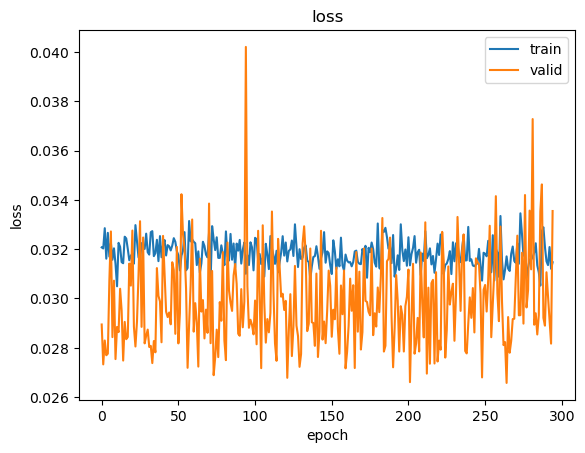

In [39]:
# loss 
plt.plot(ckpt['history']['train_loss'][5:],label='train')
plt.plot(ckpt['history']['valid_loss'][5:],label='valid')
plt.legend()
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')